# Image processing tutorial

## References
https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch


### Import libraries

In [10]:
# python libraries
import os
import random
import errno
import csv

# data sciense libraries
import numpy as np

# display libraries
import matplotlib.pyplot as plt
from IPython.display import display

# image processing libraries
from PIL import Image
import cv2

#### Foreground image.
Read foreground image and display.

##### Color notes

White	   #FFFFFF	<br>
100%(Red)  (255)    <br>
100%(Green)(255)    <br>
100%(Blue) (255)    <br>
Black	  #000000	<br>


Foreground image shape  (284, 383, 4)


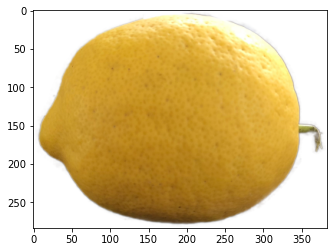

In [19]:
foreground = Image.open('../data/lemon_example/foregrounds/lemon_01.png')
fg_img_array = np.asarray(foreground)
print('Foreground image shape ', fg_img_array.shape)
plt.imshow(fg_img_array)
plt.show()

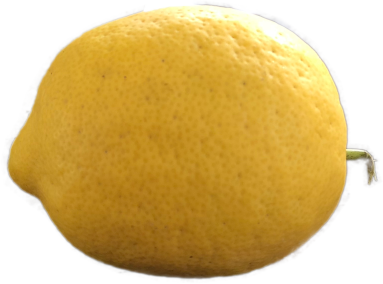

In [17]:
# another way to display image
display(foreground)

#### Foreground images requires transparency which is checked below
For foreground images which are .png images provides transparency information. 
We can think of all image with full black color (which value is 0) as background. And if we have lemon image on that
then we have values not equal to zero in that part of image, usually in white color (i.e., value 255 or some thing like that).
Here we check for alpha for zero beacuse if we have transparency we can look background color zero value in other part of image
other than lemon part of the image.

In [8]:
foreground_alpha = np.array(foreground.getchannel(3))
assert np.any(foreground_alpha == 0), 'foreground needs to have some transparency: {}'.format(foreground_path)

#### Background image
Open back ground image and convert it to RGBA type which contains alpha channel.

Background image shape  (756, 1008, 3)


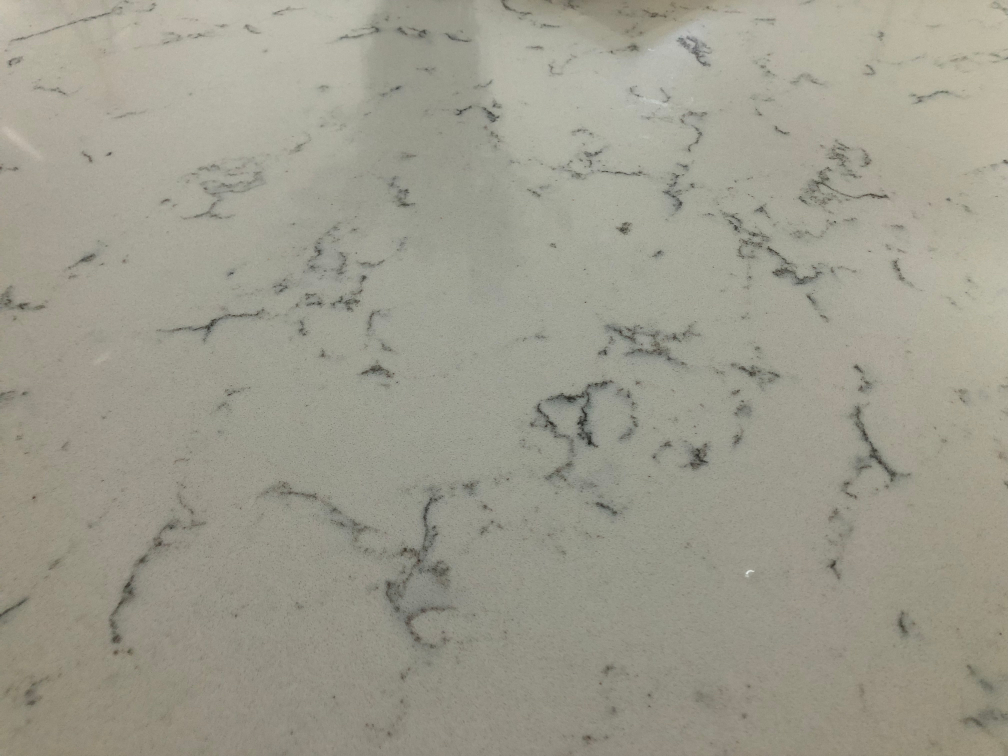

In [21]:
background = Image.open('../data/lemon_example/backgrounds/bg_01.jpg')
print('Background image shape ', np.asarray(background).shape) # note for jpg there is no alpha channel
background = background.convert('RGBA')
display(background)

### Perform transformations on foreground images

Transformed foreground image shape  (168, 161, 4)


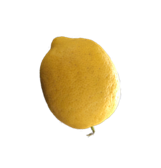

In [24]:
# Rotate the foreground
angle_degrees = random.randint(0, 359)
foreground = foreground.rotate(angle_degrees, resample=Image.BICUBIC, expand=True)
    
# Scale the foreground
import random
scale = random.random() * .5 + .5 # Pick something between .5 and 1
new_size = (int(foreground.size[0] * scale), int(foreground.size[1] * scale))
foreground = foreground.resize(new_size, resample=Image.BICUBIC)

#### Choose random postion for forground image on backgroud image.
Create new image same size as back ground where we paste our transformed foreground image at random position.
Here we create new image as same size of background image because in PIL we use 'composite' API which requires
arguments provided to be of same shape.

In addition in PIL there is following limitation

       In 'composite' we canot past foreground image with transparent back ground on top of background image directly,
       so we create new mask image (new_alpha_mask)separetely with black color back ground with size same as
       orignal background image and pasting transformed foreground alpha mask on created mask image (new_alpha_mask).
       
       e.g., composite = Image.composite(new_foreground, background, new_alpha_mask) 
       
##### PIL Composite API

PIL.Image.composite(image1, image2, mask)
Create composite image by blending images using a transparency mask.

Parameters
image1 – The first image.

image2 – The second image. Must have the same mode and size as the first image.

mask – A mask image. This image can have mode “1”, “L”, or “RGBA”, and must have the same size as the other two images. 
 

In [26]:
# Choose a random x,y position for the foreground
max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
assert max_xy_position[0] >= 0 and max_xy_position[1] >= 0, \
    'foreground {} is to big for the background {}'.format(foreground_path, background_path)
    
paste_position = (random.randint(0, max_xy_position[0]), random.randint(0, max_xy_position[1]))

print('foreground image to be pasted at position ', paste_position)

# Create a new foreground image as large as the background and paste it on top.
# Here color = (0, 0, 0, 0) Back ground color is black, but we are having transperncy (alpha) value as 0 means zero visibility
# i.e., once image is on top of the image, the image behind is not seen.

new_foreground = Image.new('RGBA', background.size, (0,0,0,0))
# display(new_foreground)
new_foreground.show()
cv2.waitKey(0) 
#closing all open windows 
cv2.destroyAllWindows() 

foreground image to be pasted at position  (508, 507)


#### new_foreground = Image.new('RGBA', background.size, (0,0,0,100)) produes following output

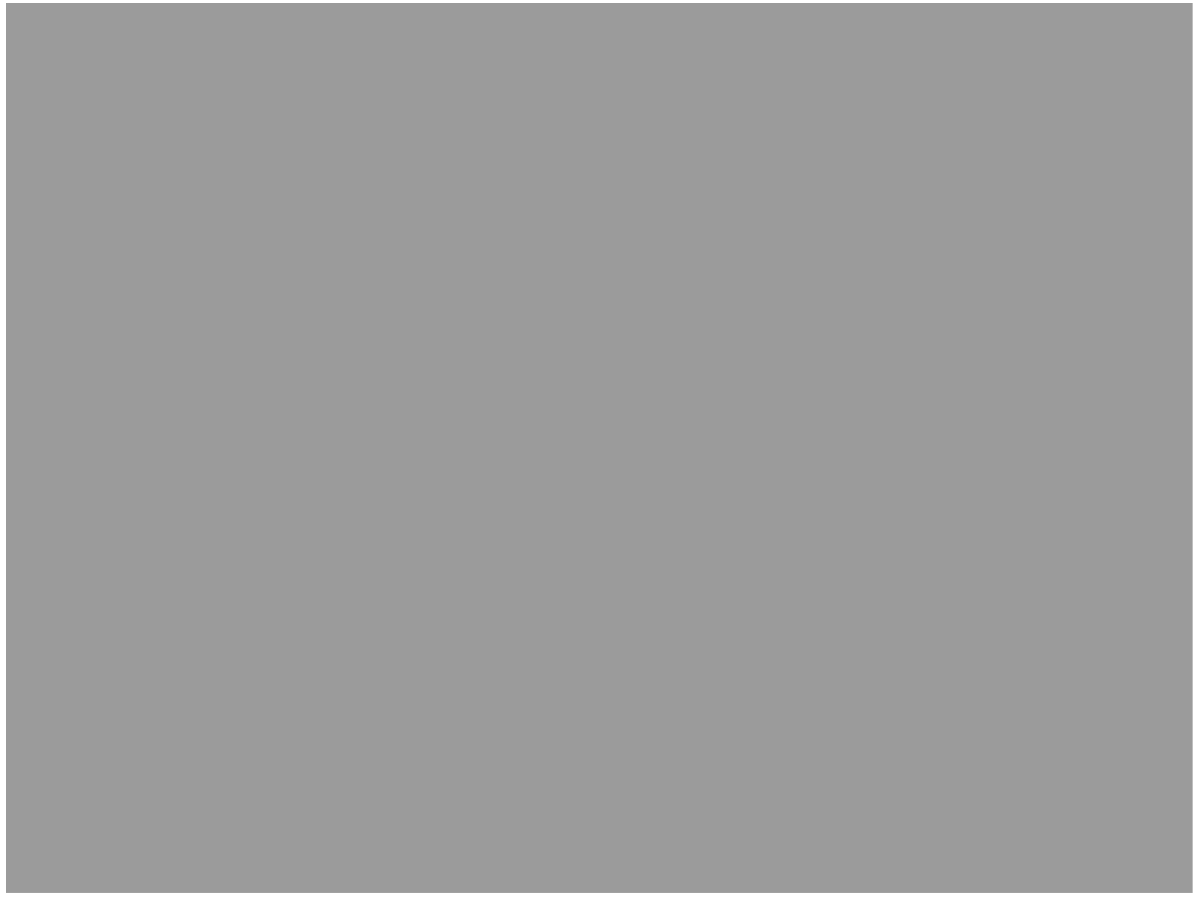


#### new_foreground = Image.new('RGBA', background.size, (0,0,0,0))
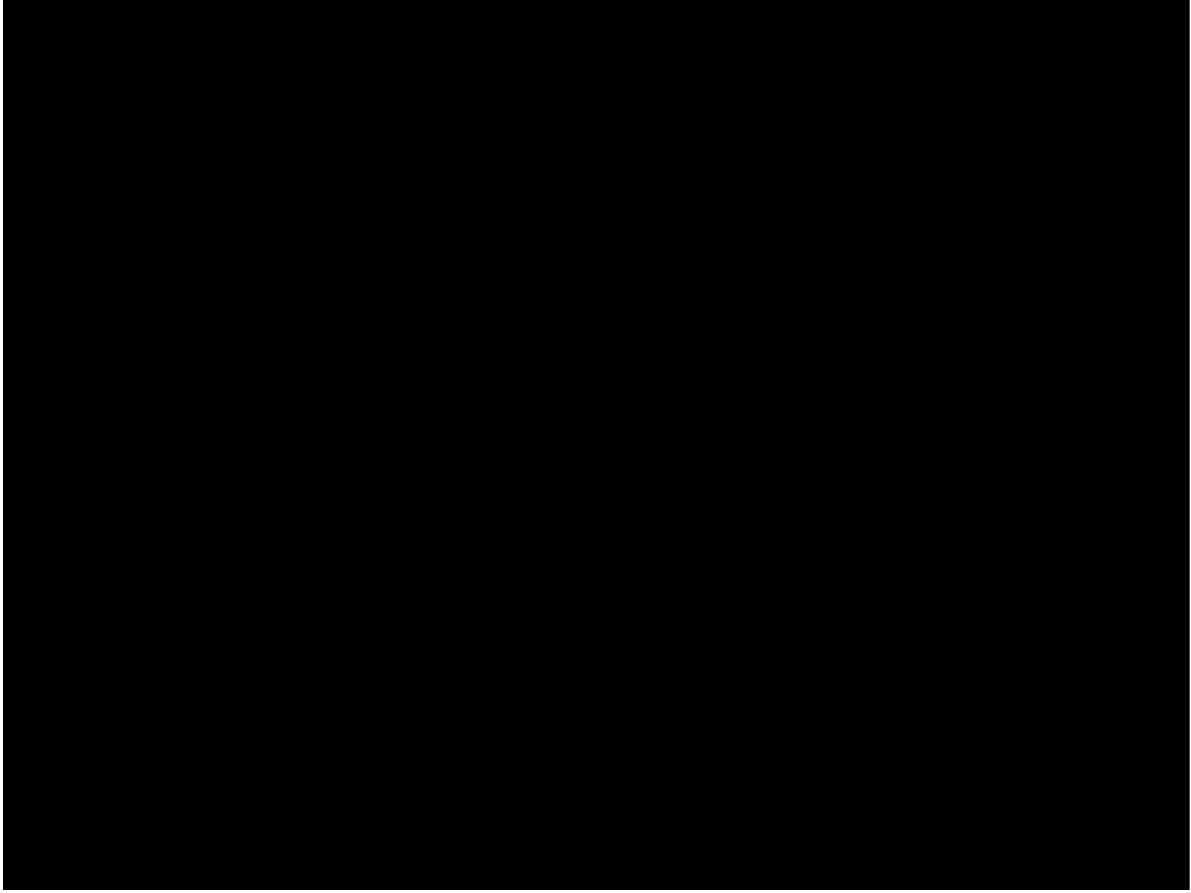

In [29]:
new_foreground.paste(foreground, paste_position)
new_foreground.show() 
  
#waits for user to press any key 
#(this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0) 
  
#closing all open windows 
cv2.destroyAllWindows() 

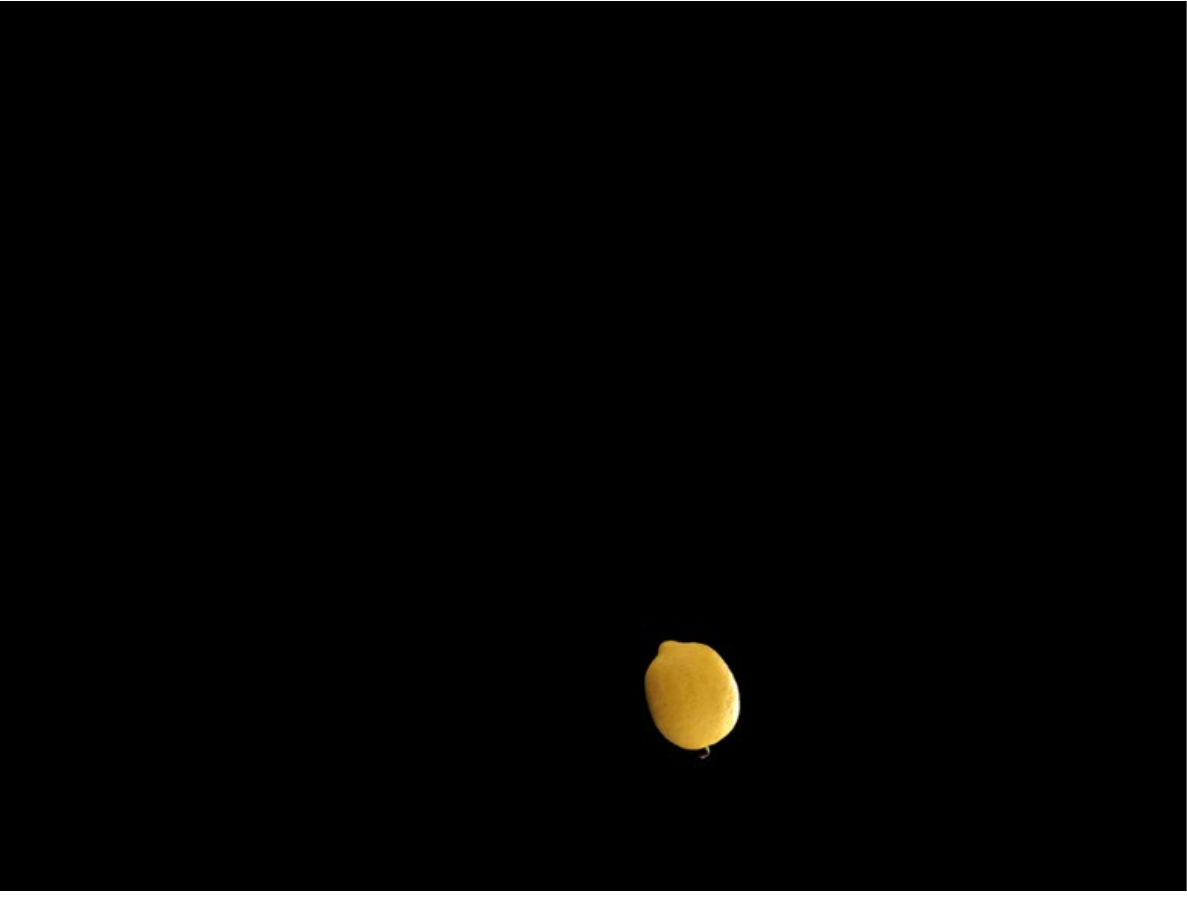

alpha channel shape  (168, 161)
alpha mask 80 80 value  255
Number of bytes in image is 27048


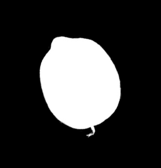

In [42]:
alpha_mask = foreground.getchannel(3) # we can think of transparency channel (alpha channel as ). To my understanding for 
                                      # alpha channel we remove background (if we have black ground in original image).
                                      #  A value of 0 means that the pixel is fully transparent and does not provide any
                                      # coverage information;
                                      # i.e. there is no occlusion at the image pixel window because the geometry
                                      # did not overlap this pixel. A value of 1 means that the pixel is 
                                      # fully opaque because the geometry completely overlaps the pixel window
print('alpha channel shape ', np.array(alpha_mask).shape)
print('alpha mask 80 80 value ', np.array(alpha_mask)[80][80]) # notice here middle we have non zero value and where black color 
alphaData = foreground.tobytes("raw", "A")               # is present value is zero.
print ('Number of bytes in image is', len(alphaData))

display(alpha_mask)                                      



new_alpha mask number of bands are  4
new_alpha mask image mode is  RGBA
new_alpha mask image shape is  (1008, 756)


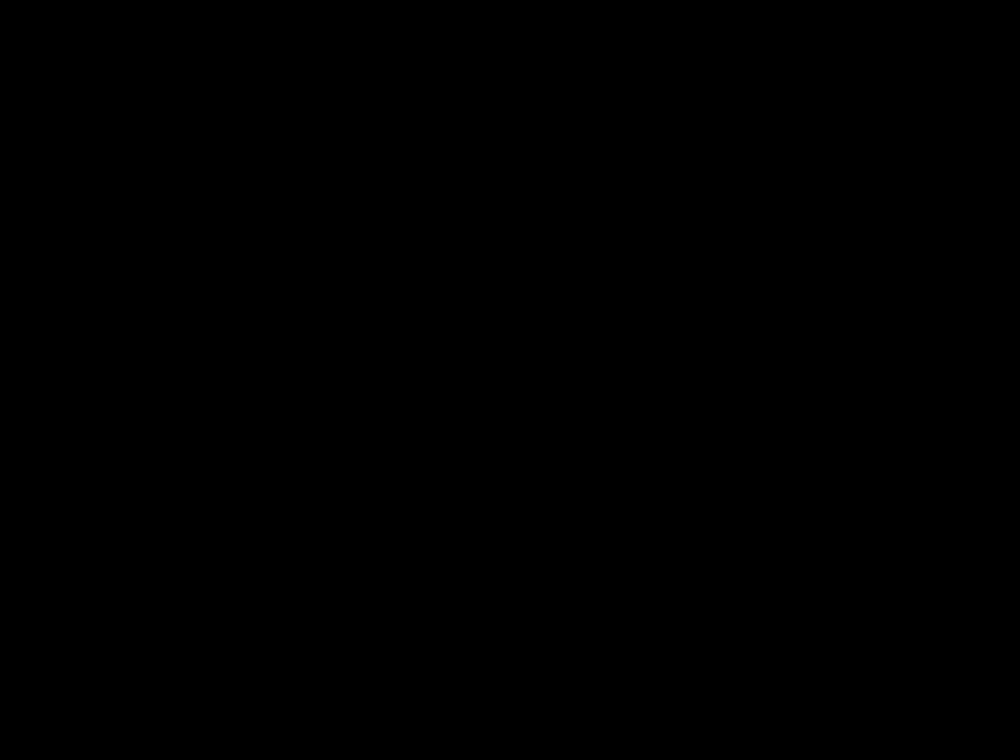

In [44]:
# https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes. 
# L (8-bit pixels, black and white)
# RGBA  (4x8-bit pixels, true color with transparency mask)
# L means gray scale every pixel value is between 0 and 1.
# Below color =0 means black.
new_alpha_mask = Image.new('L', background.size, color=0)
print('new_alpha mask number of bands are ', len(new_foreground.getbands()))
print('new_alpha mask image mode is ', new_foreground.mode)
print('new_alpha mask image shape is ', new_foreground.size)
display(new_alpha_mask)

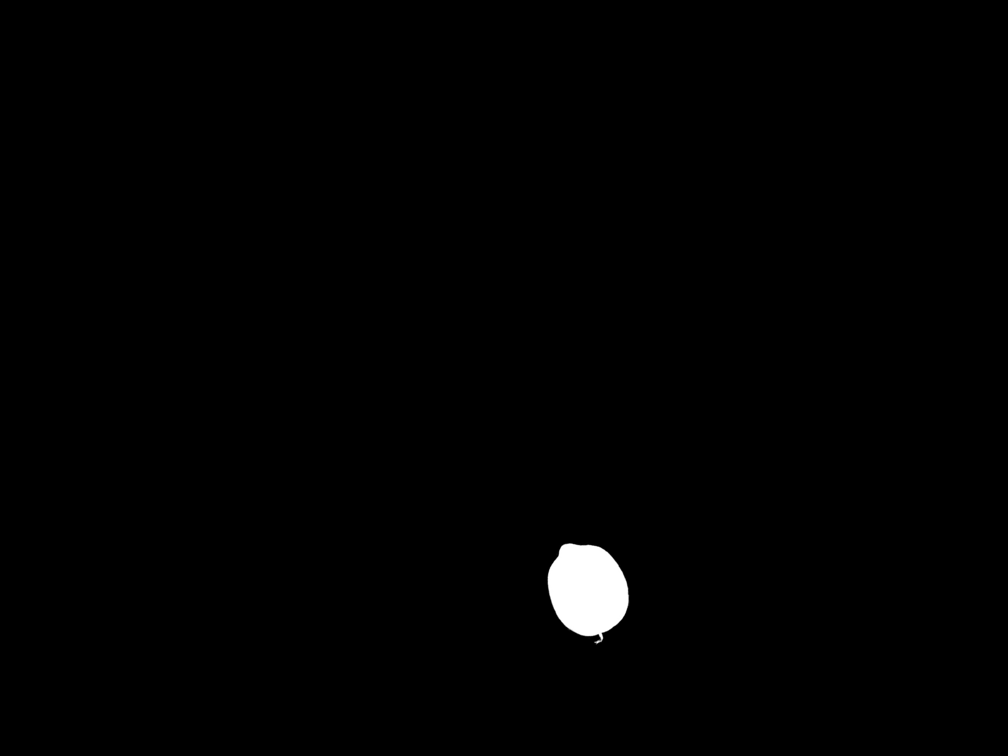

In [46]:
new_alpha_mask.paste(alpha_mask, paste_position)
display(new_alpha_mask)

### Here we compose all the images i.e., transformed foreground image, background image, and foreground image mask

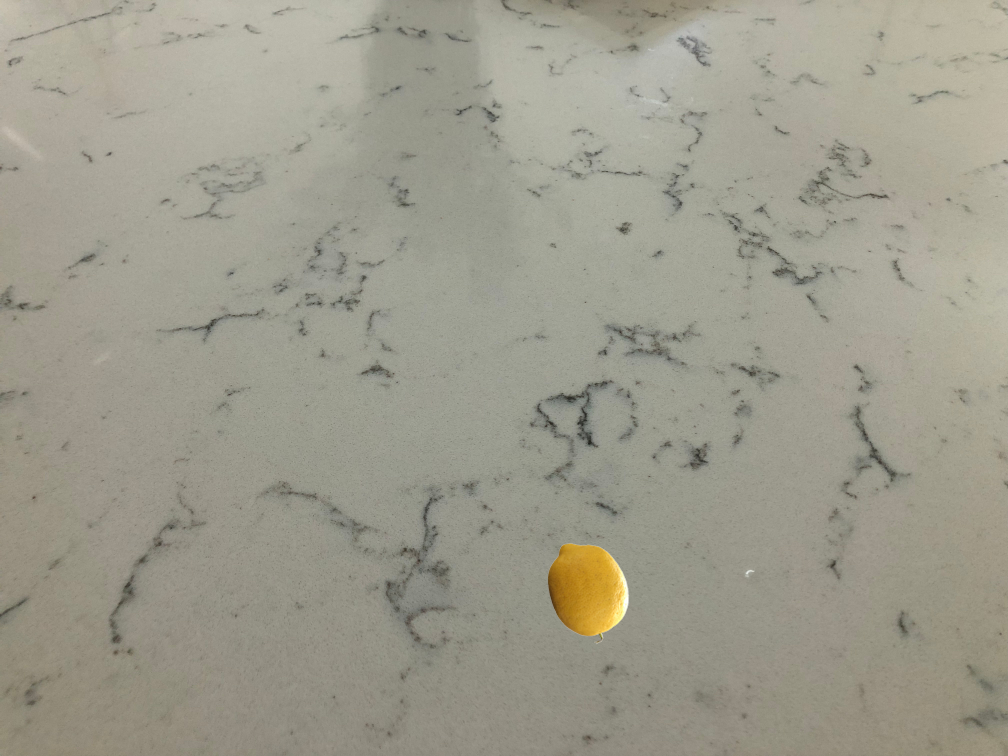

In [48]:
# note below new_alpha_mask determines what is visible on top.
'''
PIL.Image.composite(image1, image2, mask)[source]
Create composite image by blending images using a transparency mask.

Parameters
image1 – The first image.

image2 – The second image. Must have the same mode and size as the first image.

mask – A mask image. This image can have mode “1”, “L”, or “RGBA”, and must have the same size as the other two images.
'''
# Below we paste foreground on top of back ground and then specify what is alpha mask.
# composite method we canot past foreground image with transparent back ground on top of background image directly.
# so we paste together first and then we will show actual image i.e., See udactiy video compose images and masks at 3:30
composite = Image.composite(new_foreground, background, new_alpha_mask) # so here we will show actual image i.e., lime with 
                                                                        # back ground with transprency channel correctly.

display(composite)

### Create image mask
Image mask helps us in annotating automatically. With the help of image and corresponding image mask we can programatically create automations like bounding box, annotations,required for COCO format specifications.

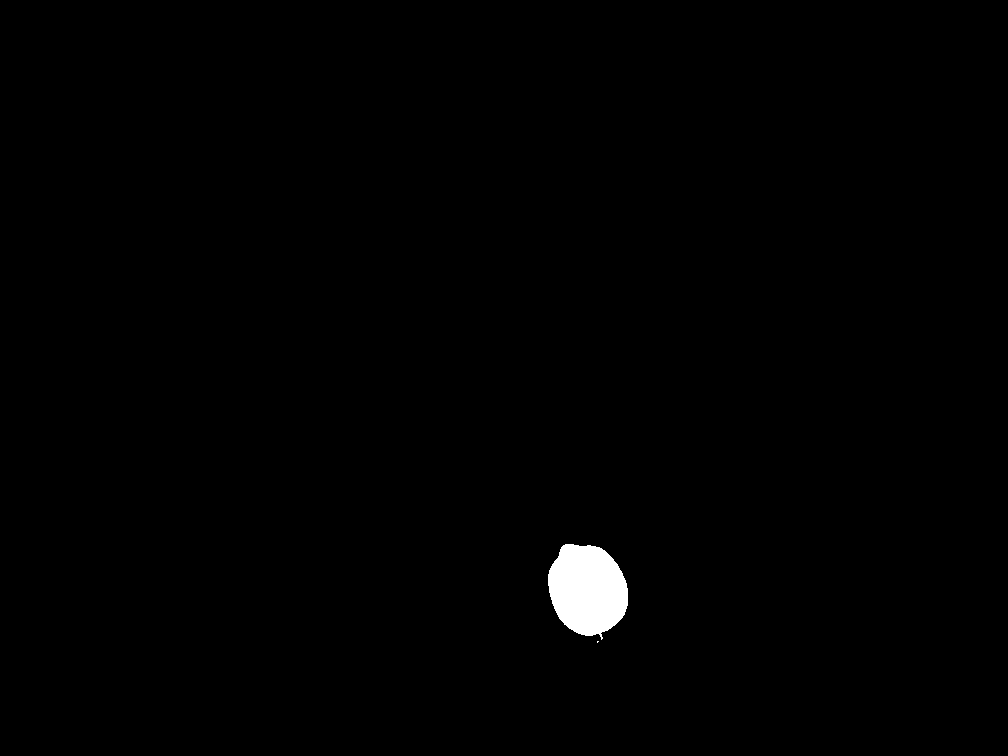

In [50]:
# Grab the alpha pixels above a specified threshold. 
alpha_threshold = 200
mask_arr = np.array(np.greater(np.array(new_alpha_mask), alpha_threshold), dtype=np.uint8)
# fromarry Creates an image memory from an object exporting the array interface (using the buffer protocol).
hard_mask = Image.fromarray(np.uint8(mask_arr) * 255, 'L')
display(hard_mask)

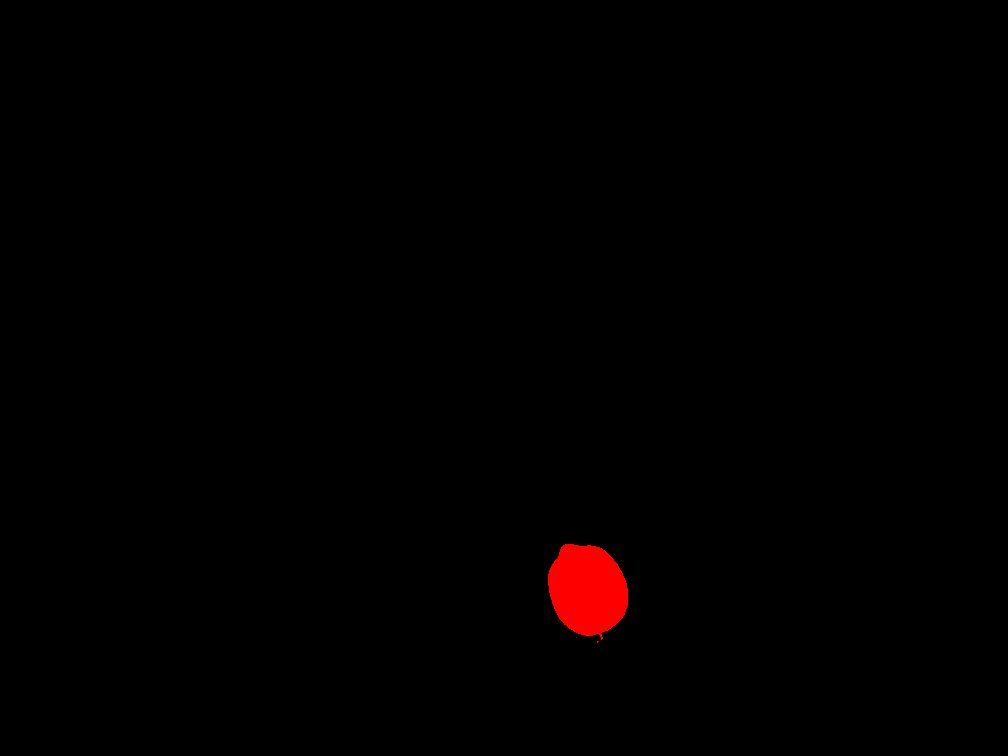

In [54]:
# Grab the alpha pixels above a specified threshold
alpha_threshold = 200
mask_arr = np.array(np.greater(np.array(new_alpha_mask), alpha_threshold), dtype=np.uint8)
uint8_mask = np.uint8(mask_arr) # This is composed of 1s and 0s

composite_mask = Image.new('RGB', background.size, 0)

# Multiply the mask value (1 or 0) by the color in each RGB channel and combine to get the mask
mask_rgb_color = (255, 0, 0)
red_channel = uint8_mask * mask_rgb_color[0]
green_channel = uint8_mask * mask_rgb_color[1]
blue_channel = uint8_mask * mask_rgb_color[2]
rgb_mask_arr = np.dstack((red_channel, green_channel, blue_channel))
isolated_mask = Image.fromarray(rgb_mask_arr, 'RGB')
isolated_alpha = Image.fromarray(uint8_mask * 255, 'L')

composite_mask = Image.composite(isolated_mask, composite_mask, isolated_alpha)
display(composite_mask)

In [20]:
# Get the smallest & largest non-zero values in each dimension and calculate the bounding box
nz = np.nonzero(hard_mask)

bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])]
bbox

[201, 371, 439, 613]

In [22]:
# study for back ground channel
ch_background = Image.open('bg_01.jpg')

ch_background.show()
cv2.waitKey(0) 
#closing all open windows 
cv2.destroyAllWindows() 
ch_background_arr = np.array(ch_background)
print('shape of ch_background is ', ch_background.size)
print('ch_background_arr ', ch_background_arr.shape)

shape of ch_background is  (1008, 756)
ch_background_arr  (756, 1008, 3)


In [25]:
ch_alpha_background = ch_background.convert('RGBA')
ch_background_arr = np.array(ch_alpha_background)
print('shape of ch_background is ', ch_alpha_background.size)
print('ch_background_arr ', ch_background_arr.shape)
print('value of transparent ', ch_background_arr[3] )

shape of ch_background is  (1008, 756)
ch_background_arr  (756, 1008, 4)
value of transparent  [[200 193 175 255]
 [200 193 175 255]
 [200 193 177 255]
 ...
 [184 179 160 255]
 [182 177 158 255]
 [182 176 162 255]]


In [27]:
background_alpha = np.array(ch_background_arr[3])
assert np.any(background_alpha == 0), 'background_alpha needs to have some transparency: '

AssertionError: background_alpha needs to have some transparency: 

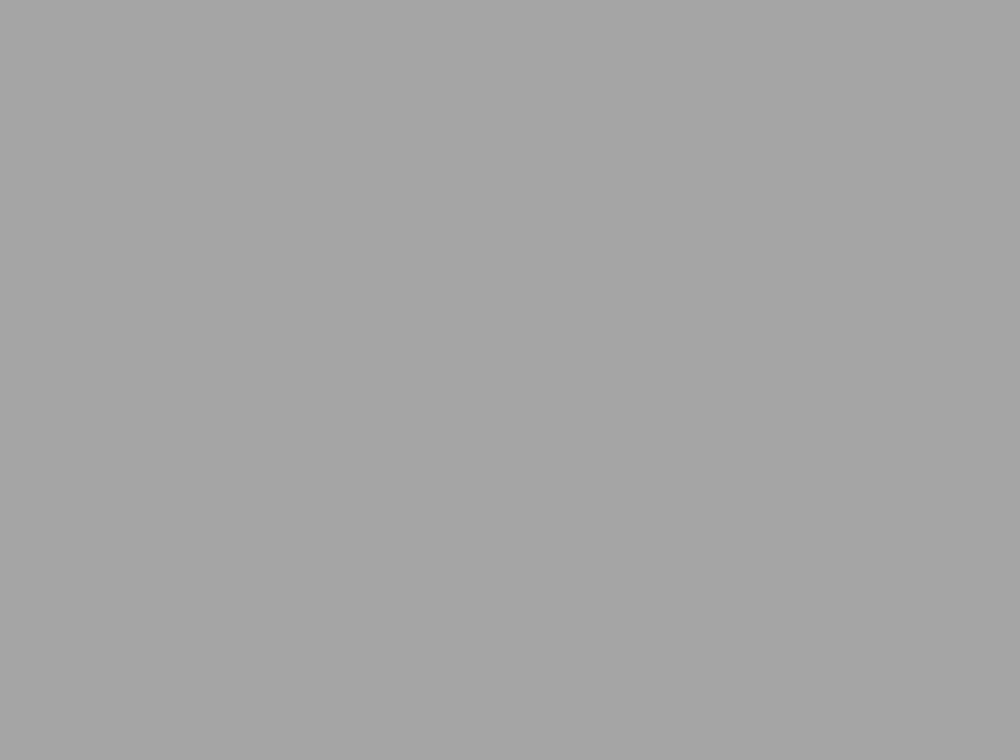

In [62]:
vrk_test_new_foreground = Image.new('RGBA', background.size, (0,0,0,90))

display(vrk_test_new_foreground)


In [ ]:
i